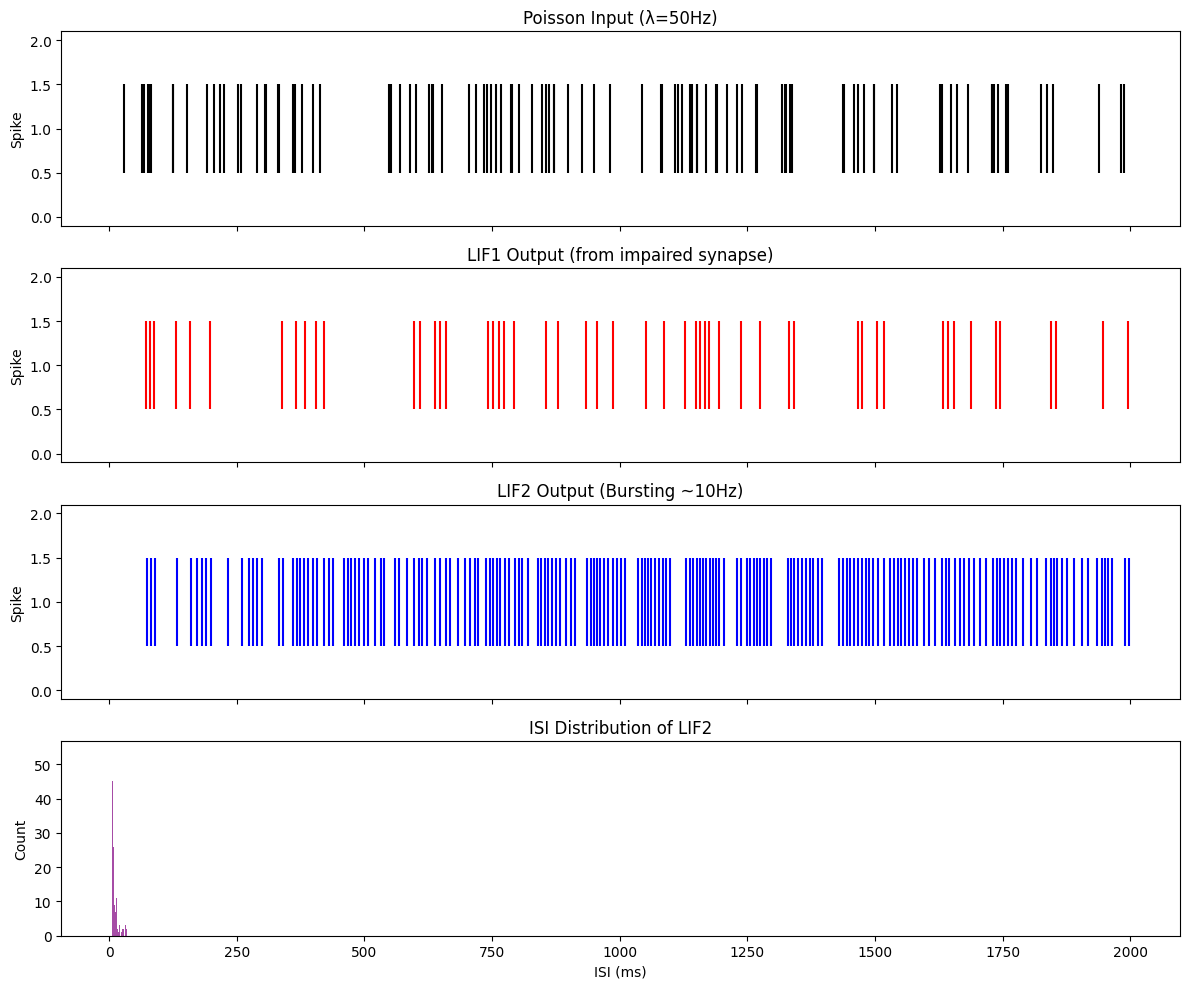

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 基本参数 ----------
dt = 0.1  # ms
T = 2000  # 总时间(ms)
time = np.arange(0, T, dt)
n_steps = len(time)

# ---------- Poisson 输入 ----------
rate_input = 50  # Hz
poisson_spikes = np.random.rand(n_steps) < rate_input * dt / 1000

# ---------- 突触模型：模拟囊泡释放为指数电流 ----------
def synaptic_current(spike_train, tau_syn=5.0, weight=0.5):
    I = np.zeros_like(spike_train, dtype=float)
    for i in range(1, len(spike_train)):
        I[i] = I[i-1] * np.exp(-dt / tau_syn)
        if spike_train[i]:
            I[i] += weight
    return I

# ---------- LIF 模型 ----------
def LIF(I, tau_m=20.0, R=1.0, v_th=1.0, v_reset=0.0, refractory=5.0):
    v = 0.0
    spikes = np.zeros_like(I)
    t_last_spike = -np.inf
    for t in range(len(I)):
        if (t - t_last_spike) * dt < refractory:
            continue
        dv = (-v + R * I[t]) / tau_m * dt
        v += dv
        if v >= v_th:
            spikes[t] = 1
            v = v_reset
            t_last_spike = t
    return spikes

# ---------- 模拟第一个神经元 ----------
release_prob = 0.5
delayed_spikes = np.zeros_like(poisson_spikes)
delay_steps = int(5 / dt)
for i in range(delay_steps, n_steps):
    if poisson_spikes[i - delay_steps] and np.random.rand() < release_prob:
        delayed_spikes[i] = 1

I1 = synaptic_current(delayed_spikes, tau_syn=5.0, weight=1.0)
LIF1_spikes = LIF(I1, v_th=0.5, R=5.0)

# ---------- LIF1 → LIF2 模拟 burst 模式 ----------
def burst_input_from_spikes(spike_train, burst_rate=10, burst_length=5):
    burst_input = np.zeros_like(spike_train)
    spike_indices = np.where(spike_train)[0]
    isi = int(1000 / burst_rate / dt)
    for idx in spike_indices:
        for j in range(burst_length):
            t = idx + j * isi
            if t < len(spike_train):
                burst_input[t] = 1
    return burst_input

burst_input = burst_input_from_spikes(LIF1_spikes, burst_rate=10, burst_length=5)
I2 = synaptic_current(burst_input, tau_syn=5.0, weight=1.0)
LIF2_spikes = LIF(I2, v_th=0.5, R=5.0)

# ---------- ISI 计算 ----------
def compute_isi(spike_train):
    spike_times = np.where(spike_train)[0] * dt
    return np.diff(spike_times)

isi_LIF2 = compute_isi(LIF2_spikes)

# ---------- 绘图 ----------
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].eventplot(np.where(poisson_spikes)[0] * dt, color='black')
axs[0].set_title("Poisson Input (λ=50Hz)")
axs[0].set_ylabel("Spike")

axs[1].eventplot(np.where(LIF1_spikes)[0] * dt, color='red')
axs[1].set_title("LIF1 Output (from impaired synapse)")
axs[1].set_ylabel("Spike")

axs[2].eventplot(np.where(LIF2_spikes)[0] * dt, color='blue')
axs[2].set_title("LIF2 Output (Bursting ~10Hz)")
axs[2].set_ylabel("Spike")

axs[3].hist(isi_LIF2, bins=30, color='purple', alpha=0.7)
axs[3].set_title("ISI Distribution of LIF2")
axs[3].set_xlabel("ISI (ms)")
axs[3].set_ylabel("Count")

plt.tight_layout()
plt.show()
